<h1><center>IMT2118 - Ciencia de Datos Geoespaciales (2024-1) </center></h1>
<h2><center>Proyecto:   </center></h2>

### Imports

In [114]:
import pandas as pd
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import geemap, ee
from shapely.geometry import LineString

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

### Lectura de Datos

In [115]:
stgo = gpd.read_file("Datos/santiago_urbano.gpkg")
roi_shapely = stgo.union_all()

In [116]:
Areas_Verdes = gpd.read_file("Datos/Areas_Verdes.gpkg")
Bomberos = gpd.read_file("Datos/Bomberos.gpkg")
Censo_2017 = gpd.read_file("Datos/Censo_2017.gpkg")
Comercio = gpd.read_file("Datos/Comercio.gpkg")
Ejes = gpd.read_file("Datos/Ejes.gpkg")
EstablecimientosSalud = gpd.read_file("Datos/EstablecimientosSalud.gpkg")
Limite_Comunal = gpd.read_file("Datos/Limite_Comunal.gpkg")
Manzanas = gpd.read_file("Datos/Manzanas.gpkg")
Paraderos = gpd.read_file("Datos/Paraderos.gpkg")

In [117]:
Areas_Verdes = Areas_Verdes[Areas_Verdes.geometry.within(roi_shapely)]
Bomberos = Bomberos[Bomberos.geometry.within(roi_shapely)]
Censo_2017 = Censo_2017[Censo_2017.geometry.within(roi_shapely)]
Comercio = Comercio[Comercio.geometry.within(roi_shapely)]
Ejes = Ejes[Ejes.geometry.within(roi_shapely)]
EstablecimientosSalud = EstablecimientosSalud[EstablecimientosSalud.geometry.within(roi_shapely)]
Manzanas = Manzanas[Manzanas.geometry.within(roi_shapely)]
Paraderos = Paraderos[Paraderos.geometry.within(roi_shapely)]

### Comunas

Filtramos que el Limite comunal solo incluya nuestra zona de interes

In [118]:
Limite_Comunal['geometry'] = Limite_Comunal.geometry.intersection(roi_shapely)
Limite_Comunal = Limite_Comunal[~Limite_Comunal.is_empty]

In [119]:
m = geemap.Map(center=[-33.45, -70.65], zoom=12)
m.add_gdf(stgo, "Santiago Urbano", style={'color': 'blue', 'fillOpacity': 0.1})
m.add_gdf(Limite_Comunal, "Comunas Recortadas", style={'color': 'black', 'fillOpacity': 0.4, 'weight': 2})
m

Map(center=[-33.45, -70.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

## Metro

In [120]:
df = pd.read_csv("Datos/plantilla_metro.csv", decimal=',')
for col in ['Lat Origen', 'Long Origen', 'Lat Destino', 'Long Destino']:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

df['geometry'] = df.apply(
    lambda row: LineString([
        (row['Long Origen'], row['Lat Origen']),
        (row['Long Destino'], row['Lat Destino'])
    ]),
    axis=1
)

Metro = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
Metro['linea'] = Metro['linea'].astype(str)

colores_lineas = {
    '1': 'E1251B',
    '2': 'FFD600',
    '3': '682600',
    '4': '0072BC',
    '4A': '5FAEE2',
    '5': '365A05',
    '6': 'B303DF'
}
Metro['color'] = Metro['linea'].map(colores_lineas)

features = []
for _, row in Metro.iterrows():
    geom = geemap.geopandas_to_ee(gpd.GeoDataFrame([row], crs="EPSG:4326")).geometry()
    feature = ee.Feature(geom).set('style', {
        'color': row['color'],
        'width': 4,
        'lineType': 'solid'
    })
    features.append(feature)

fc = ee.FeatureCollection(features)

m_metro = geemap.Map(center=[-33.45, -70.65], zoom=12)
m_metro.addLayer(fc.style(**{'styleProperty': 'style'}), {}, 'Lineas de Metro')
m_metro


Map(center=[-33.45, -70.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [121]:
from shapely.geometry import Point

estaciones = pd.concat([
    Metro[['Estación Origen', 'Lat Origen', 'Long Origen']].rename(
        columns={'Estación Origen': 'Estacion', 'Lat Origen': 'Lat', 'Long Origen': 'Lon'}),
    Metro[['Estación Destino', 'Lat Destino', 'Long Destino']].rename(
        columns={'Estación Destino': 'Estacion', 'Lat Destino': 'Lat', 'Long Destino': 'Lon'})
], ignore_index=True).drop_duplicates(subset=['Estacion'])

estaciones['geometry'] = estaciones.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)
gdf_estaciones = gpd.GeoDataFrame(estaciones, geometry='geometry', crs="EPSG:4326")

gdf_estaciones_comunas = gpd.sjoin(gdf_estaciones, Limite_Comunal, how='left', predicate='within')

conteo = gdf_estaciones_comunas['comuna'].value_counts().sort_index()

comunas_todas = Limite_Comunal['comuna'].unique()

comunas_sin_metro = set(comunas_todas) - set(conteo.index)

#print("Estaciones de metro por comuna:")
#print(conteo)
print("Comunas sin estaciones de metro:")
print(sorted(comunas_sin_metro))


Comunas sin estaciones de metro:
['CERRO NAVIA', 'COLINA', 'HUECHURABA', 'LA PINTANA', 'LAMPA', 'LO BARNECHEA', 'LO ESPEJO', 'RENCA', 'VITACURA']


In [122]:
# Crear personas_por_comuna agrupando por nombre de comuna
personas_por_comuna = Manzanas.groupby('DES_COMU')['PERSONAS'].sum()

# Filtrar las comunas sin metro en personas_por_comuna
personas_sin_metro = personas_por_comuna[personas_por_comuna.index.isin(comunas_sin_metro)]
print(personas_sin_metro)
print(f"Total de personas en comunas sin metro: {personas_sin_metro.sum()}")

DES_COMU
CERRO NAVIA     120684
HUECHURABA       51721
LA PINTANA      174065
LAMPA                4
LO BARNECHEA     60448
LO ESPEJO        98651
RENCA           110913
VITACURA         76696
Name: PERSONAS, dtype: int64
Total de personas en comunas sin metro: 693182


In [123]:
zonas = gpd.read_file("Datos/datosZonas_Stgo_C2017.gpkg").to_crs("EPSG:4326")

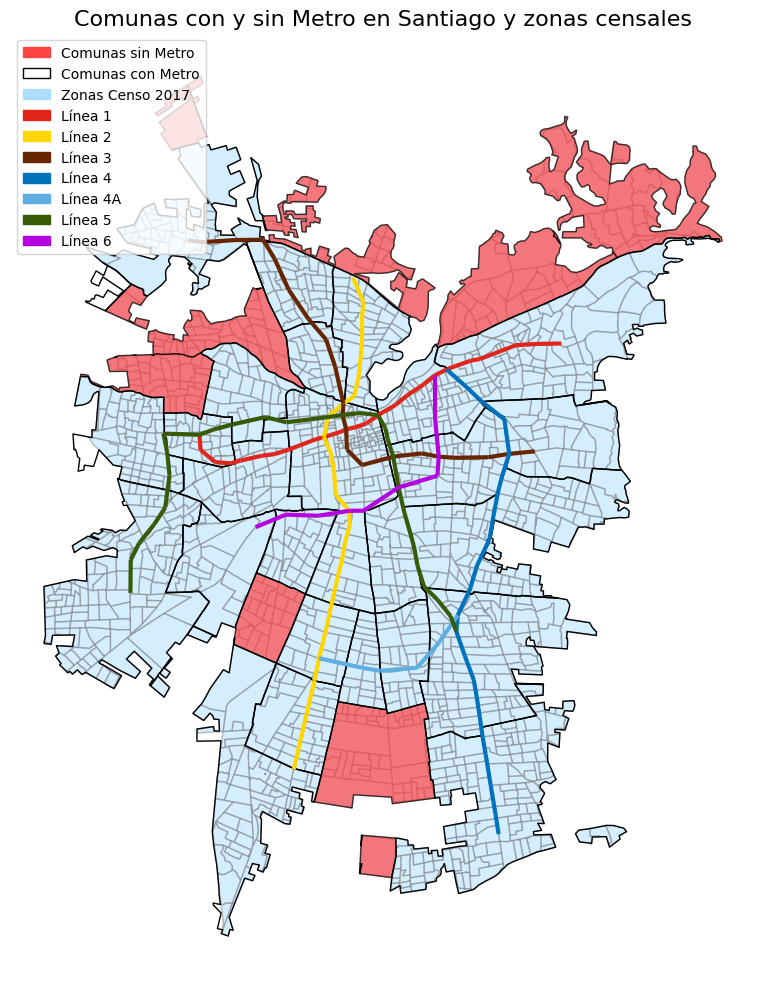

In [124]:
import matplotlib.patches as mpatches


Limite_Comunal_plot = Limite_Comunal.copy()
Limite_Comunal_plot['sin_metro'] = Limite_Comunal_plot['comuna'].str.upper().isin(comunas_sin_metro)

fig, ax = plt.subplots(figsize=(12, 10))

# 1. Zonas censales (fondo)
zonas.plot(ax=ax, color='#aaddff', edgecolor='gray', alpha=0.5, label='Zonas Censo 2017')

# 2. Comunas sin metro con color
Limite_Comunal_plot[Limite_Comunal_plot['sin_metro']].plot(
    ax=ax,
    color='#ff4444',
    edgecolor='black',
    linewidth=1,
    alpha=0.7,
    label='Comunas sin Metro'
)

# 3. Resto de comunas solo borde
Limite_Comunal_plot[~Limite_Comunal_plot['sin_metro']].plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=1,
    alpha=1,
    label='Comunas con Metro'
)

# 4. Líneas de metro con sus colores
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(
        ax=ax,
        color=f'#{color}',
        linewidth=3,
        label=f'Línea {linea}'
    )

# 5. Leyenda manual
leyenda = [
    mpatches.Patch(color='#ff4444', label='Comunas sin Metro'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Comunas con Metro'),
    mpatches.Patch(color='#aaddff', label='Zonas Censo 2017')
]
for linea, color in colores_lineas.items():
    leyenda.append(mpatches.Patch(color=f'#{color}', label=f'Línea {linea}'))

ax.legend(handles=leyenda, loc='upper left', fontsize=10)

ax.set_title('Comunas con y sin Metro en Santiago y zonas censales', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


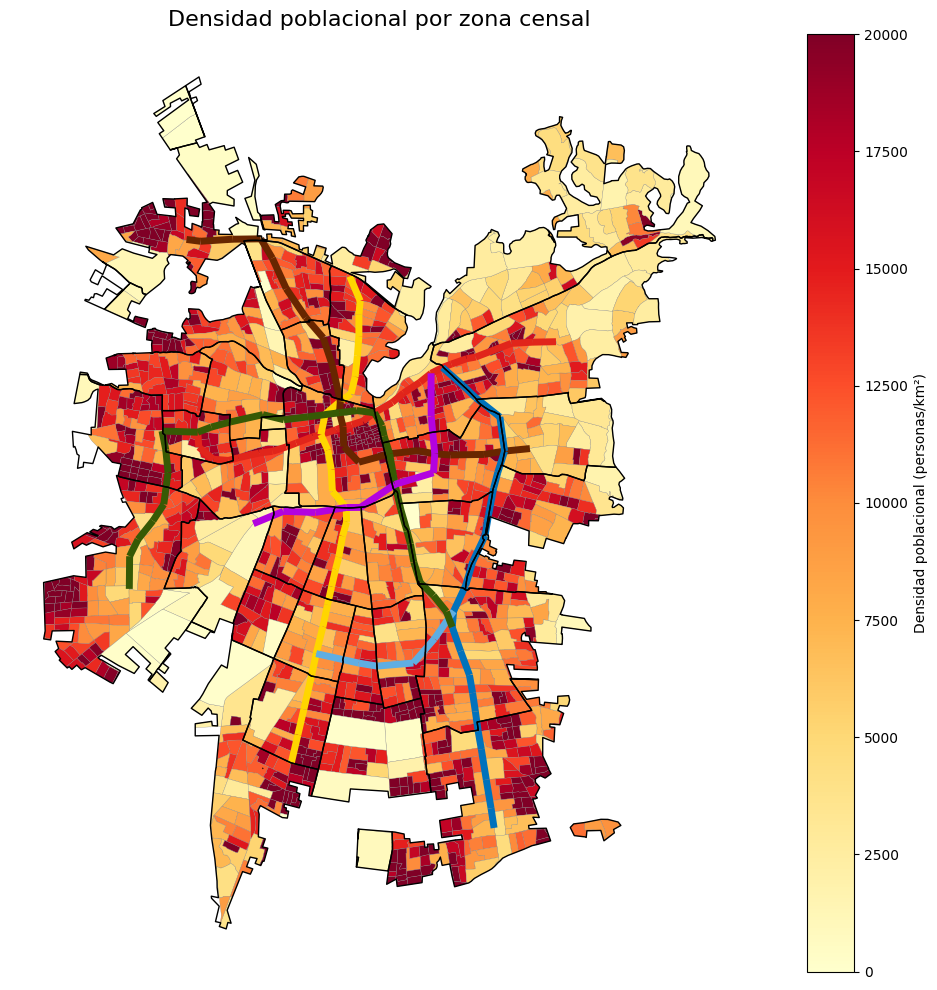

In [129]:
# Calcular área en km² si no existe y luego la densidad
if 'densidad' not in zonas.columns:
    # Proyectar a CRS métrico para calcular área si es necesario
    if zonas.crs is None or zonas.crs.to_epsg() != 32719:
        zonas_proj = zonas.to_crs(epsg=32719)
    else:
        zonas_proj = zonas.copy()
    zonas['area_km2'] = zonas_proj.geometry.area / 1e6
    zonas['densidad'] = zonas['PERSONAS'] / zonas['area_km2']

fig, ax = plt.subplots(figsize=(12, 10))

# Limitar la escala máxima de densidad para mejorar la visualización
vmax = 20000  # Ajusta este valor según lo que quieras resaltar
# Dibujar las líneas de metro sobre el mapa
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(
        ax=ax,
        color=f'#{color}',
        linewidth=5,
        label=f'Línea {linea}'
    )


zonas.plot(
    column='densidad',
    ax=ax,
    cmap='YlOrRd',
    legend=True,
    legend_kwds={'label': "Densidad poblacional (personas/km²)"},
    edgecolor='gray',
    linewidth=0.2,
    vmax=vmax
)

Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title('Densidad poblacional por zona censal', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


In [130]:
import branca.colormap as cm

# Crear colormap para la densidad
dens_min, dens_max = zonas['densidad'].min(), vmax
colormap = cm.linear.YlOrRd_09.scale(dens_min, dens_max)
colormap.caption = 'Densidad poblacional (personas/km²)'

# Crear copia de zonas para evitar SettingWithCopyWarning
zonas_map = zonas.copy()
zonas_map['densidad'] = zonas_map['densidad'].clip(upper=vmax)

m_inter = geemap.Map(center=[-33.45, -70.65], zoom=12)

# Crear columna de color para cada zona según densidad
zonas_map['color'] = zonas_map['densidad'].apply(colormap)

# Añadir zonas censales coloreadas por densidad
m_inter.add_gdf(
    zonas_map,
    layer_name='Densidad poblacional',
    style={'fillColor': 'color', 'color': 'gray', 'weight': 0.5, 'fillOpacity': 0.7},
    info_mode='on_hover'  # Muestra info al pasar el mouse
)

# Añadir límites comunales
m_inter.add_gdf(
    Limite_Comunal,
    layer_name='Límites comunales',
    style={'color': 'black', 'weight': 2, 'fillOpacity': 0}
)

m_inter.addLayer(fc.style(**{'styleProperty': 'style'}), {}, 'Lineas de Metro')

# Añadir la barra de color
m_inter.add_control(colormap)

m_inter


Map(center=[-33.45, -70.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

## Aqui arriba hay que arreglar lo de densidad poblacional

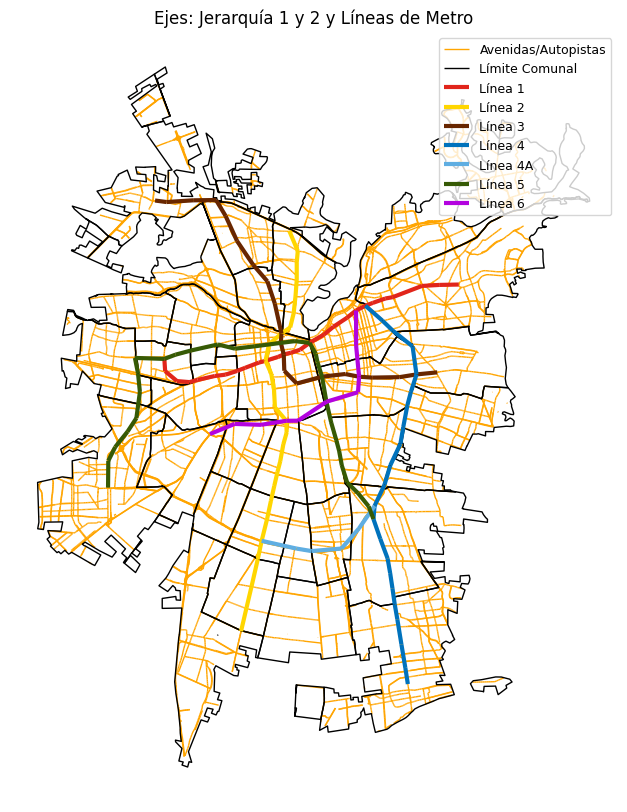

In [133]:
# Filtro Avenidas y Autopistas
filtro_jerarquia = Ejes["hierarchy"].isin([1, 2])
Ejes_jerarquia = Ejes[filtro_jerarquia]

Ejes_jerarquia = Ejes_jerarquia[Ejes_jerarquia.is_valid]
fig, ax = plt.subplots(figsize=(12, 10))
Ejes_jerarquia.plot(ax=ax, color='orange', linewidth=1, label='Avenidas/Autopistas')
Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1, label='Límite Comunal')

# Agregar líneas de metro
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(
        ax=ax,
        color=f'#{color}',
        linewidth=3,
        label=f'Línea {linea}'
    )

ax.set_title("Ejes: Jerarquía 1 y 2 y Líneas de Metro")
ax.axis('off')

# Leyenda personalizada para evitar duplicados
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), fontsize=9)

plt.show()

In [ ]:
Ejes["hierarchy"].value_counts()

hierarchy
4.0    75861
5.0    55528
2.0    25146
1.0      420
6.0       53
Name: count, dtype: int64

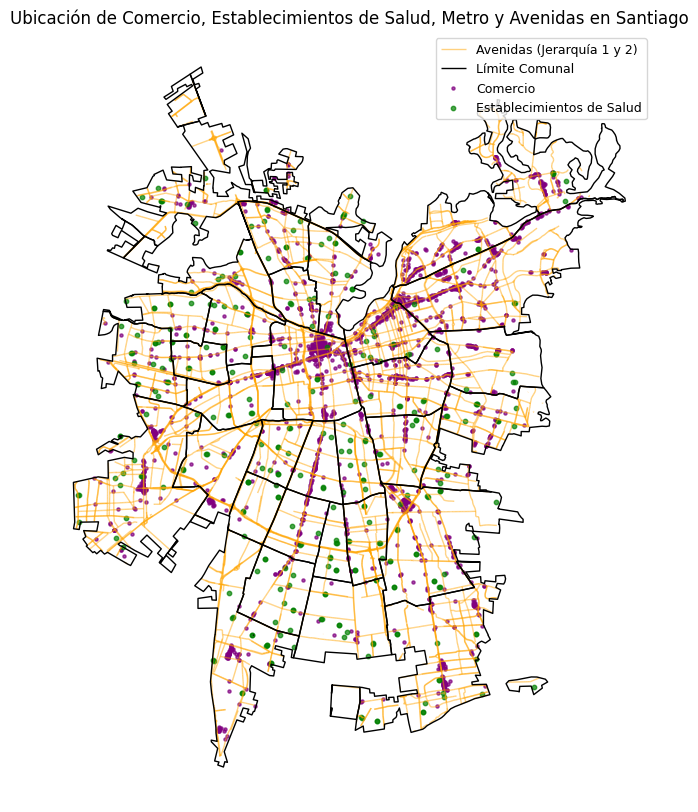

In [134]:
fig, ax = plt.subplots(figsize=(10, 10))

# 1. Avenidas (Ejes jerarquía 1 y 2) al fondo
Ejes_jerarquia.plot(ax=ax, color='orange', linewidth=1, alpha=0.5, label='Avenidas (Jerarquía 1 y 2)')

# 3. Límite comunal
Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1, label='Límite Comunal')

# 4. Comercio
Comercio.plot(ax=ax, color='purple', markersize=5, alpha=0.7, label='Comercio')

# 5. Establecimientos de Salud
EstablecimientosSalud.plot(ax=ax, color='green', markersize=10, alpha=0.7, label='Establecimientos de Salud')

ax.set_title('Ubicación de Comercio, Establecimientos de Salud, Metro y Avenidas en Santiago')
ax.axis('off')

# Leyenda personalizada para evitar duplicados
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), fontsize=9)

plt.show()